# Convolutions for Images

:label:`chapter_conv_layer`


Now that we understand how convolutional layers work in theory,
we are ready to see how this works in practice.
Since we have motivated convolutional neural networks
by their applicability to image data,
we will stick with image data in our examples,
and begin by revisiting the convolutional layer
that we introduced in the previous section.
We note that strictly speaking, *convolutional* layers are a slight misnomer,
since the operations are typically expressed as cross correlations.


## The Cross-Correlation Operator

In a convolutional layer, an input array
and a correlation kernel array are combined
to produce an output array through a cross-correlation operation.
Let's see how this works for two dimensions.
In our example, the input is a two-dimensional array
with a height of 3 and width of 3.
We mark the shape of the array as $3 \times 3$ or (3, 3).
The height and width of the kernel array are both 2.
Common names for this array in the deep learning research community
include *kernel* and *filter*.
The shape of the kernel window (also known as the convolution window)
is given precisely by the height and width of the kernel
(here it is $2 \times 2$).



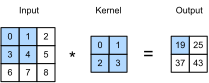

In [14]:
from IPython.display import SVG
SVG(filename = '../img/correlation.svg')

Fig:Two-dimensional cross-correlation operation. The shaded portions are the first output element and the input and kernel array elements used in its computation: $0\times0+1\times1+3\times2+4\times3=19$. 

In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the top-left corner of the input array
and slide it across the input array,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subarray contained in that window
and the kernel array are multiplied (element-wise)
and the resulting array is summed up
yielding a single scalar value.
This result if precisely the value of the output array
at the corresponding location.
Here, the output array has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axi, the output is slightly *smaller* than the input.
Because the kernel has a width greater than one,
and we can only computer the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $H \times W$
minus the size of the convolutional kernel $h \times w$
via $(H-h+1) \times (W-w+1)$.
This is the case since we need enough space
to 'shift' the convolutional kernel across the image
(later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
such that there's enough space to shift the kernel).
Next, we implement the above process in the `corr2d` function.
It accepts the input array `X` with the kernel array `K`
and outputs the array `Y`.

In [15]:
import torch
from torch import nn

# This function has been saved in the d2l package for future use
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

We can construct the input array `X` and the kernel array `K`
from the figure above
to validate the output of the above implementations
of the two-dimensional cross-correlation operation.

In [16]:
X = torch.Tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.Tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolutional Layers

A convolutional layer cross-correlates the input and kernels
and adds a scalar bias to produce an output.
The parameters of the convolutional layer
are precisely the values that constitute the kernel and the scalar bias.
When training the models based on convolutional layers,
we typically initialize the kernels randomly,
just as we would with a fully-connected layer.

We are now ready to implement a two-dimensional convolutional layer
based on the `corr2d` function defined above.
In the `__init__` constructor function,
we declare `weight` and `bias` as the two model parameters.
The forward computation function `forward`
calls the `corr2d` function and adds the bias.
As with $h \times w$ cross-correlation
we also refer to convolutional layers
as $h \times w$ convolutions.

In [17]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = torch.rand(kernel_size,dtype=torch.float32,requires_grad=True)
        self.bias = torch.zeros((1,),dtype=torch.float32,requires_grad=True)

    def forward(self, x):
        
        return corr2d(x, self.weight) + self.bias

## Object Edge Detection in Images

Let's look at a simple application of a convolutional layer:
detecting the edge of an object in an image
by finding the location of the pixel change.
First, we construct an 'image' of $6\times 8$ pixels.
The middle four columns are black (0) and the rest are white (1).

In [18]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, we construct a kernel `K` with a height of 1 and width of 2.
When we perform the cross-correlation operation with the input,
if the horizontally adjacent elements are the same,
the output is 0. Otherwise, the output is non-zero.

In [19]:
K = torch.Tensor([[1, -1]])

Enter `X` and our designed kernel `K`
to perform the cross-correlation operations.
As you can see, we will detect 1 for the edge from white to black
and -1 for the edge from black to white.
The rest of the outputs are 0.

In [20]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Let's apply the kernel to the transposed image.
As expected, it vanishes. The kernel `K` only detects vertical edges.

In [21]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Learning a Kernel

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let's see whether we can learn the kernel that generated `Y` from `X`
by looking at the (input, output) pairs only.
We first construct a convolutional layer
and initialize its kernel as a random array.
Next, in each iteration, we will use the squared error
to compare `Y` and the output of the convolutional layer,
then calculate the gradient to update the weight.
For the sake of simplicity, in this convolutional layer,
we will ignores the bias.

We previously constructed the `Conv2D` class.But here we are using the `nn.Conv2D` from the Pytorch libraries. The custom class `Conv2D` that we created can be used similarly.

In [22]:
# Construct a convolutional layer with 1 output channel
# (channels will be introduced in the following section)
# and a kernel array shape of (1, 2)

conv2d = nn.Conv2d(1,1, kernel_size=(1, 2),bias=False) #For sake of simplicity ignoring bias

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))


for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
   
    conv2d.zero_grad()
    l.sum().backward()
    # For the sake of simplicity, we ignore the bias here
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print('batch %d, loss %.3f' % (i + 1, l.sum()))

batch 2, loss 5.672
batch 4, loss 1.359
batch 6, loss 0.395
batch 8, loss 0.134
batch 10, loss 0.051


As you can see, the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel array we learned.

In [23]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0121, -0.9671]])

Indeed, the learned kernel array is remarkably close
to the kernel array `K` we defined earlier.

## Cross-correlation and Convolution

Recall the observation from the previous section
that cross-correlation and convolution are equivalent.
In the figure above it is easy to see this correspondence.
Simply flip the kernel from the bottom left to the top right.
In this case the indexing in the sum is reverted,
yet the same result can be obtained.
In keeping with standard terminology with deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different.

## Summary

* The core computation of a two-dimensional convolutional layer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
* We can design a kernel to detect edges in images.
* We can learn the kernel through data.

## Exercises

1. Construct an image `X` with diagonal edges.
    * What happens if you apply the kernel `K` to it?
    * What happens if you transpose `X`?
    * What happens if you transpose `K`?
1. How do you represent a cross-correlation operation as a matrix multiplication by changing the input and kernel arrays?
1. Design some kernels manually.
    * What is the form of a kernel for the second derivative?
    * What is the kernel for the Laplace operator?
    * What is the kernel for an integral?
    * What is the minimum size of a kernel to obtain a derivative of degree $d$?



